In [2]:
# Securely enter your API key
from getpass import getpass
import requests

API_KEY = getpass("Enter your Google Generative AI API key: ")

MODEL = "models/gemini-2.0-flash"
URL = f"https://generativelanguage.googleapis.com/v1beta/{MODEL}:generateContent"

def ask_llm(prompt, temperature=0.7, max_output_tokens=200):
    headers = {
        "Content-Type": "application/json",
        "X-goog-api-key": API_KEY
    }
    data = {
        "contents": [{"role": "user", "parts": [{"text": prompt}]}],
        "generationConfig": {
            "temperature": temperature,
            "maxOutputTokens": max_output_tokens
        }
    }
    response = requests.post(URL, headers=headers, json=data)
    if response.status_code != 200:
        return f"Error {response.status_code}: {response.text}"
    resp_json = response.json()
    try:
        candidates = resp_json.get("candidates", [])
        if not candidates:
            return "No candidates returned."
        content = candidates[0].get("content", {})
        parts = content.get("parts", [])
        if not parts:
            return "No text generated."
        text = parts[0].get("text", "").strip()
        return text
    except Exception as e:
        return f"Error parsing response: {e}\nRaw: {resp_json}"


Enter your Google Generative AI API key: ··········


In [3]:
def experiment_llm(prompt, temperatures=[0.2,0.7,1.0], top_ps=[0.3,0.8,1.0], max_tokens=100):
    results = []

    print(f"=== Prompt ===\n{prompt}\n")

    # Temperature experiments (keeping top-p default)
    for temp in temperatures:
        response = ask_llm(prompt, temperature=temp, max_output_tokens=max_tokens)
        results.append({"Parameter": f"Temperature={temp}", "Response": response})

    # Top-p experiments (keeping temperature default 0.7)
    # Gemini API uses temperature mainly; top-p can be simulated via instruction in prompt
    for tp in top_ps:
        modified_prompt = f"{prompt}\n(Use top-p setting: {tp} - prefer safe words if top-p low)"
        response = ask_llm(modified_prompt, temperature=0.7, max_output_tokens=max_tokens)
        results.append({"Parameter": f"Top-p={tp}", "Response": response})

    return results


In [4]:
prompt = "Write a creative one-line ghost story which makes you scared."

results = experiment_llm(prompt)

for r in results:
    print(f"{r['Parameter']}:")
    print(r['Response'])
    print("-"*50)


=== Prompt ===
Write a creative one-line ghost story which makes you scared.

Temperature=0.2:
The antique music box chimed a lullaby I didn't recognize, and the reflection in its polished lid wasn't mine.
--------------------------------------------------
Temperature=0.7:
The old house stood silent, the only sound the faint, rhythmic *thump-thump* coming from the attic, getting louder, always louder, because the baby's heartbeat wasn't supposed to be there anymore.
--------------------------------------------------
Temperature=1.0:
The antique rocking chair in my empty nursery started swaying, and I haven't owned a rocking chair, or a nursery, in years.
--------------------------------------------------
Top-p=0.3:
The old house stood silent, except for the faint scratching from inside the walls... and my reflection in the darkened window wasn't mine.
--------------------------------------------------
Top-p=0.8:
The antique mirror whispered my name with my mother's voice, but she'd bee

In [5]:
import pandas as pd

df = pd.DataFrame(results)
df


,Parameter,Response
0,Temperature=0.2,The antique music box chimed a lullaby I didn'...
1,Temperature=0.7,"The old house stood silent, the only sound the..."
2,Temperature=1.0,The antique rocking chair in my empty nursery ...
3,Top-p=0.3,"The old house stood silent, except for the fai..."
4,Top-p=0.8,The antique mirror whispered my name with my m...
5,Top-p=1.0,"The reflection winked, and I was alone."


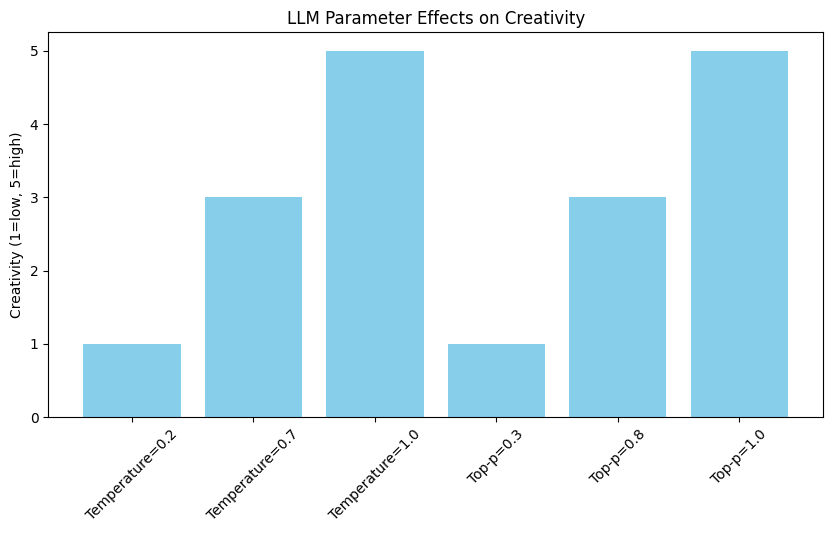

In [6]:
import matplotlib.pyplot as plt

# Example results (replace with your actual experiment_llm outputs)
results = [
    {"Parameter": "Temperature=0.2", "Response": "The antique music box chimed a lullaby I didn't recognize, and then I saw my reflection in the polished wood, but it was rocking a baby I never had."},
    {"Parameter": "Temperature=0.7", "Response": "The antique music box played a lullaby my deceased mother used to sing, and then a child's voice whispered, \"She's here now, too.\""},
    {"Parameter": "Temperature=1.0", "Response": "The old house sighed, and I realized the spiderweb draped across my face wasn't made of silk."},
    {"Parameter": "Top-p=0.3", "Response": "The old house stood silent, but the swing set in the backyard creaked in a rhythm only *it* could hear, a lullaby from a child that wasn't there, yet desperately wanted to be."},
    {"Parameter": "Top-p=0.8", "Response": "The antique mirror whispered my name, and the reflection that answered wasn't mine."},
    {"Parameter": "Top-p=1.0", "Response": "The reflection in the mirror winked, and I realized I don't have a reflection."}
]


# Convert to DataFrame for easier plotting
import pandas as pd
df = pd.DataFrame(results)

# Plot creativity scale (manually assign)
creativity_score = [1, 3, 5, 1, 3, 5]  # simple 1-5 scale for study purposes
df['Creativity'] = creativity_score

plt.figure(figsize=(10,5))
plt.bar(df['Parameter'], df['Creativity'], color='skyblue')
plt.title("LLM Parameter Effects on Creativity")
plt.ylabel("Creativity (1=low, 5=high)")
plt.xticks(rotation=45)
plt.show()


In [7]:
import numpy as np

# Simple metrics for analysis
df["Word Count"] = df["Response"].apply(lambda x: len(str(x).split()))
df["Unique Words"] = df["Response"].apply(lambda x: len(set(str(x).split())))
df["Lexical Diversity"] = df["Unique Words"] / df["Word Count"]

df[["Parameter", "Word Count", "Lexical Diversity", "Response"]]


,Parameter,Word Count,Lexical Diversity,Response
0,Temperature=0.2,29,0.896552,The antique music box chimed a lullaby I didn'...
1,Temperature=0.7,23,0.956522,The antique music box played a lullaby my dece...
2,Temperature=1.0,17,1.000000,"The old house sighed, and I realized the spide..."
3,Top-p=0.3,33,0.878788,"The old house stood silent, but the swing set ..."
4,Top-p=0.8,13,1.000000,"The antique mirror whispered my name, and the ..."
5,Top-p=1.0,14,0.928571,"The reflection in the mirror winked, and I rea..."
